# PROJECT. Расчёт статистической значимости

Компания: клининговый сервис Qlean
Цель: сделать анализ эффективности новой фичи

Задачи:
1. Рассчитать, насколько различаются конверсия, средний чек и ARPU пользователей в группах А и Б (ID теста 127, даты проведения: с 2019-08-05 до 2019-08-11 включительно).
2. Сформировать выводы по анализу.

In [2]:
# Импортируем нужные библиотеки и функции

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime

In [4]:
# Читаем таблицу ab_test_groups

ab_test_groups = pd.read_csv('ab_test_groups.csv')
# ab_test_groups

In [7]:
# Из таблицы с участниками А/Б-теста выберем только пользователей с идентификатором теста равным 127
ab_test_groups_127 = ab_test_groups.loc[ab_test_groups.ab_test_id == 127]
ab_test_groups_127

,user_id,grp,ab_test_id
11999,1,B,127
12000,2,B,127
12001,3,B,127
12002,4,B,127
12003,5,A,127
...,...,...,...
165226,153228,A,127
165227,153229,B,127
165228,153230,B,127
165229,153231,B,127


In [8]:
# Читаем таблицу payments
payments = pd.read_csv('payments.csv')
payments

,payment_id,user_id,price,created_at,tariff
0,1,77831,200.0,2019-08-05 00:00:54,month
1,2,84576,200.0,2019-08-05 00:01:05,month
2,3,40981,140.0,2019-08-05 00:03:47,month_30off
3,4,130565,140.0,2019-08-05 00:09:33,month_30off
4,5,34758,700.0,2019-08-05 00:12:16,year_30off
...,...,...,...,...,...
14634,14635,9924,130.0,2019-08-18 22:54:57,month_35off
14635,14636,3722,650.0,2019-08-18 22:59:37,year_35off
14636,14637,5571,200.0,2019-08-18 23:02:54,month
14637,14638,11044,200.0,2019-08-18 23:13:54,month


In [9]:
# Фильтруем данные в таблице payments в соответствии с датой проведения теста 127 (с 2019-08-05 до 2019-08-11 включительно)

payments_127 = payments.loc[(payments.created_at.astype(str) >= '2019-08-05') & 
                        (payments.created_at.astype(str) < '2019-08-12'), ['user_id', 'price']]
payments_127

,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0
...,...,...
13701,2313,140.0
13702,139246,700.0
13703,42885,200.0
13704,129593,700.0


In [10]:
# Проводим аггрегацию по пользователю
payments_127 = payments_127.groupby('user_id', as_index = False).agg({'price': 'sum'})
payments_127

,user_id,price
0,1,140.0
1,10,140.0
2,23,140.0
3,24,700.0
4,39,140.0
...,...,...
13701,153184,140.0
13702,153190,140.0
13703,153205,140.0
13704,153212,700.0


In [11]:
# Создаём сводную таблицу с информацией обо всех участниках теста 127 и покупках каждого из них за время теста.
ab_data_127 = ab_test_groups_127.merge(payments_127, on = 'user_id', how = 'left')
ab_data_127

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN
...,...,...,...,...
153227,153228,A,127,NaN
153228,153229,B,127,NaN
153229,153230,B,127,NaN
153230,153231,B,127,NaN


In [12]:
# Посмотрим, в каких пропорциях разбиты пользователи на группы и какое количество пользователей в каждой группе что-то купило:

#Агрегация данных
ab_summary_127 = ab_data_127.groupby('grp').agg({'user_id': 'count', 'price': 'count'})
#Переименовывание столбцов
ab_summary_127.rename(columns = {'user_id': 'users_count', 'price': 'buyers_count'}, inplace = True) 
ab_summary_127

,users_count,buyers_count
grp,,
A,76605,4279
B,76627,9427


In [13]:
# Считаем какая доля пользователей находится в группе А.
ab_summary_127.loc[ab_summary_127.index == 'A', 'users_count'].sum() / ab_summary_127.users_count.sum()

0.4999282134280046

Как мы видим, в группе А — 49,99 % пользователей, из чего можем сделать вывод, что использована разбивка 50/50 (0,001%, скорее всего, случайное отклонение). При этом количество покупателей существенно различается.

In [14]:
# Считаем конверсию пользователя в покупателя
ab_summary_127['conversion'] = ab_summary_127.buyers_count / ab_summary_127.users_count
ab_summary_127

,users_count,buyers_count,conversion
grp,,,
A,76605,4279,0.055858
B,76627,9427,0.123025


Конверсия различается больше чем в 2 раза: в первой группе она составляет 5.59 %, а во второй — целых 12.30 %

In [15]:
# Считаем средний чек покупки в каждой группе

# Сделали агрегацию и прикрепили её к ab_summary_127
ab_summary_127 = ab_summary_127.merge(ab_data_127.groupby('grp').agg({'price': 'mean'}).rename(columns = {'price': 'avg_bill'}), 
                             left_index = True, right_index = True)
ab_summary_127

,users_count,buyers_count,conversion,avg_bill
grp,,,,
A,76605,4279,0.055858,396.120589
B,76627,9427,0.123025,348.804498


Несмотря на то что скидка в группе Б составляет 30%, средний чек упал на ~11.94%.

In [16]:
# Считаем ARPU пользователей, а также дополнительную выручку, которую принесла группа Б.

# Сделали агрегацию и прикрепили её к ab_summary_127
ab_summary_127 = ab_summary_127.merge(ab_data_127.groupby('grp').agg({'price': 'sum'}).rename(columns = {'price': 'revenue'}), 
                              left_index = True, right_index = True) 
ab_summary_127['ARPU'] = ab_summary_127.revenue / ab_summary_127.users_count
ab_summary_127['Доп. выручка'] = ab_summary_127.users_count * (ab_summary_127.ARPU - ab_summary_127.loc['A', 'ARPU'])
ab_summary_127

,users_count,buyers_count,conversion,avg_bill,revenue,ARPU,Доп. выручка
grp,,,,,,,
A,76605,4279,0.055858,396.120589,1695000.0,22.126493,0.000000e+00
B,76627,9427,0.123025,348.804498,3288180.0,42.911506,1.592693e+06


In [ ]:
ARPU выросло на 93.94 % — отличный результат!  —  однако дополнительной выручки очень мало, всего 1592693 (~1.59 млн) рублей.

### СЧИТАЕМ ЗНАЧИМОСТЬ ИЗМЕНЕНИЯ КОНВЕРСИИ для теста 127

Мы будем использовать statsmodels.stats.weightstats.ztest, куда передадим две последовательности пользовательских конверсий

In [17]:
ztest(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0), #Конверсии пользователей группы А
     ab_data_127.loc[ab_data_127.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0) #Конверсии пользователей группы B
     )

(-46.38627328408593, 0.0)

Z-тест выдаёт два параметра: z-статистику и p-значение. p-значение настолько мало, что позволяет говорить о фактическом улучшении конверсии.

### СЧИТАЕМ ИЗМЕНЕНИЯ СРЕДНЕГО ЧЕКА И ARPU для теста 127

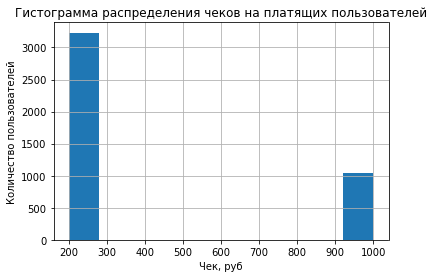

Shapiro-Wilk p-value is 0.0


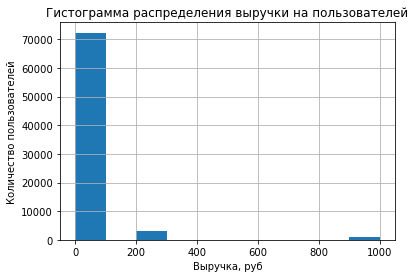

Shapiro-Wilk p-value is 0.0


C:\Users\Max\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [18]:
ax = plt.subplot()
ab_data_127.loc[ab_data_127.grp == 'A', 'price'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].dropna())[1])

ax = plt.subplot()
ab_data_127.loc[ab_data_127.grp == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].fillna(0))[1])

И визуальный анализ, и тест Шапиро-Вилка на нормальность говорят нам, что распределение не является нормальным 
(stats.shapiro выдаёт два числа, второе — p-значение сравнения нормального распределения и нашего).

### СРАВНИВАЕМ СРЕДНИЕ ЧЕКИ для теста 127

Для этого выполним тест Манна-Уитни

In [19]:
print(stats.mannwhitneyu(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].dropna(), 
                         ab_data_127.loc[ab_data_127.grp == 'B', 'price'].dropna()),
     stats.ttest_ind(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].dropna(), 
                     ab_data_127.loc[ab_data_127.grp == 'B', 'price'].dropna()),
     sep = '\n')

MannwhitneyuResult(statistic=11353450.0, pvalue=0.0)
Ttest_indResult(statistic=8.681488291725874, pvalue=4.342920451712972e-18)


Как мы видим, средние чеки различаются (p-значение < 0.05) по каждому из тестов.

### СРАВНИВАЕМ ARPU для теста 127

In [20]:
print(stats.mannwhitneyu(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].fillna(0), 
                         ab_data_127.loc[ab_data_127.grp == 'B', 'price'].fillna(0)),
     stats.ttest_ind(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].fillna(0), 
                     ab_data_127.loc[ab_data_127.grp == 'B', 'price'].fillna(0)),
     sep = '\n')

MannwhitneyuResult(statistic=2746687083.0, pvalue=0.0)
Ttest_indResult(statistic=-29.893345238870868, pvalue=8.818064407002295e-196)


По ARPU, хотя тест Манна-Уитни говорит, что распределения разные, Т-тест говорит, что средние этих распределений различить можно, т.к. p-значения больше порога равного 0,05. Таким образом, можно предположить, что А/Б-тест увеличивает ARPU.

### МНОЖЕСТВЕННОЕ СРАВНЕНИЕ для теста 127 - Доверительные интервалы

In [22]:
# Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):
# Считаем доверительные интервалы для средних
    buf = (stats.t.interval(conf_level, len(data), loc = np.mean(data), scale = stats.sem(data)))
    return (buf[1] - buf[0]) / 2

def get_conf_interval_z(succ, tot):
# Считаем доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [23]:
get_conf_interval(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].fillna(0))
# Доверительный полуинтервал для АРПУ пользователей в группе А

0.8641428736438357

In [30]:
# Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals_127 = {'ARPU': {'A': get_conf_interval(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].fillna(0)), 
                           'B': get_conf_interval(ab_data_127.loc[ab_data_127.grp == 'B', 'price'].fillna(0))}, 
                  'conversion': {'A': get_conf_interval_z(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].dropna().count(), 
                                                          ab_data_127.loc[ab_data_127.grp == 'A', 'user_id'].count()),
                                'B': get_conf_interval_z(ab_data_127.loc[ab_data_127.grp == 'B', 'price'].dropna().count(),
                                                        ab_data_127.loc[ab_data_127.grp == 'B', 'user_id'].count())},
                'avg_bill': {'A': get_conf_interval(ab_data_127.loc[ab_data_127.grp == 'A', 'price'].dropna()),
                             'B': get_conf_interval(ab_data_127.loc[ab_data_127.grp == 'B', 'price'].dropna())}
                                                         }
conf_intervals_127

{'ARPU': {'A': 0.8641428736438357, 'B': 1.0537383983825563},
 'conversion': {'A': 0.0032524511174824022, 'B': 0.004651325604805509},
 'avg_bill': {'A': 10.315428393735829, 'B': 5.467446406040892}}

### ПОСТРОЕНИЕ ОТЧЁТА

In [31]:
# Удобная функция для подстановки подписей на barplot
def set_labels(axes):
# Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()
# Размер графика по оси Y
    y_shift = 0.15 * (y1 - y0)
# Дополнительное место под надписи

    for i, rect in enumerate(axes.patches):
# По всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height / 1000, 1))
            if label [-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height / 1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2
# Посередине прямоугольника
        y = height + y_shift * 0.8
# Над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8
        axes.text(x, y, label, ha = 'center', va = 'center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5 * y_shift)

In [32]:
plot_summary_127 = ab_summary_127.T
# Транспонированная таблица для удобства использования
significant_changes_127 = ['conversion', 'avg_bill']
# Метрики со статзначимыми различиями

In [33]:
# Смотрим результаты отчёта
plot_summary_127

grp,A,B
users_count,7.660500e+04,7.662700e+04
buyers_count,4.279000e+03,9.427000e+03
conversion,5.585797e-02,1.230245e-01
avg_bill,3.961206e+02,3.488045e+02
revenue,1.695000e+06,3.288180e+06
ARPU,2.212649e+01,4.291151e+01
Доп. выручка,0.000000e+00,1.592693e+06


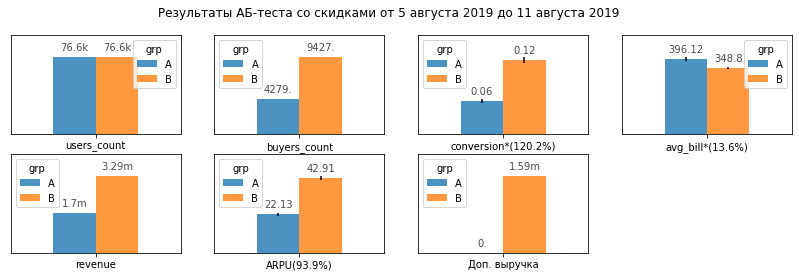

In [36]:
from matplotlib import gridspec
from math import ceil

ax = []
# Массив для складирования графиков
n_pict_in_line = 4
# Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary_127) / float(n_pict_in_line)), n_pict_in_line)
# Создаём сетку для графиков
fig = plt.figure(figsize = (n_pict_in_line * 3 + 2, ceil(len(plot_summary_127) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary_127.index:
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row and 'Доп. выручка' != row:
        delta_percent[row] = '(' + str(round(plot_summary_127.loc[row, :].max() /\
                                            plot_summary_127.loc[row, :].min() * 100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста со скидками от 5 августа 2019 до 11 августа 2019')

## Строим графики
for i, col in enumerate(plot_summary_127.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line]))
# Добавляем subplot в нужную клетку
    plot_summary_127.loc[[col], :].plot(kind = 'bar', rot = 0, ax = ax[i], alpha = 0.8,
# Строим график в нужной клетке
                                   yerr = conf_intervals_127[col] if col in conf_intervals_127 else 0)

    
# Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий
    stars = '*' if col in significant_changes_127 else ''
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes = ax[i])

### ВЫВОДЫ для теста 127

Мы получили отчёт по А/Б-тесту с интересующими нас метриками:

1. Тест успел статистически значимо повысить самую важную для нас метрику — ARPU, с 22.13 до 42.91, поэтому можем считать тест успешным.
2. ARPU значимо вырос на 93.9%.
3. Конверсия значительно увеличилась на 120.2%.
4. Средний чек незначительно упал на 13.6%.